# Mini-Project: SVM & LR Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<span style="color: blue">Remove all blue text before submitting</span>

In [97]:
%matplotlib inline
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics as mt

### Supporting Functions

In [98]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    scaler = StandardScaler()
    temp = scaler.fit_transform(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [99]:
verboseStatus = False

In [100]:
# Brett's directory
# Desktop
# %cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory. Either uncomment the cd statement above or make your own cd.
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directorY 
#%cd "C:\Users\Nicole Wittlin\Documents\7331DataMining\EducationDataNC\2017\Raw Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

print('********* Initial Values Before Cleaning *******************')
dfPublicHS.info(verbose = verboseStatus)

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
********* Initial Values Before Cleaning *******************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


In [101]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [102]:
dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].describe()

count    470.000000
mean      49.407119
std       16.665647
min        0.000000
25%       43.469064
50%       52.178615
75%       59.198851
max       89.583333
Name: ALL_All Students (Total or Subtotal_ENROLL_sch_pct, dtype: float64

In [103]:
# Evenly split our target variable (predict whether a school will have 52% postsecondary enrollment)
splitLimit = dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()

dfDropped['schoolPctTarget'] = np.where(dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= splitLimit, 1, 0)

print("{} of {}: {}%".format(dfDropped['schoolPctTarget'].sum(), dfDropped.shape[0], 
                             round(dfDropped['schoolPctTarget'].sum()/dfDropped.shape[0] * 100,2)))

235 of 470: 50.0%


In [104]:
y = dfDropped['schoolPctTarget']

In [105]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [106]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print("Columns dropped: {}".format(len(to_drop)))

Columns dropped: 124


In [107]:
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfDropped.filter(regex = r'sch_pct|college')

# Drop columns
dfDropped.drop(dropCols, axis = 1, inplace = True)

In [108]:
dfDropped.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 272 columns):
student_num                                              float64
lea_avg_student_num                                      float64
st_avg_student_num                                       float64
09_Size                                                  float64
10_Size                                                  float64
11_Size                                                  float64
12_Size                                                  float64
Biology_Size                                             float64
English II_Size                                          float64
Math I_Size                                              float64
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                         

In [109]:
# Credit: https://www.kaggle.com/saravanann/santander

# Normalize data
maxCols = dfDropped.shape[1]
X = scale_data(dfDropped.iloc[:,0:maxCols-2])

In [110]:
X.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 270 columns):
student_num                                              float64
lea_avg_student_num                                      float64
st_avg_student_num                                       float64
09_Size                                                  float64
10_Size                                                  float64
11_Size                                                  float64
12_Size                                                  float64
Biology_Size                                             float64
English II_Size                                          float64
Math I_Size                                              float64
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                         

In [111]:
#print("Top Absolute Correlations")
#print(get_top_abs_correlations(dfDropped, 150))

In [112]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


In [113]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)

In [114]:
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

#iter_num=0
# the indices are the rows used for training and testing in each iteration
#for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
#    X_train = X[train_indices]
#    y_train = y[train_indices]
    
#    X_test = X[test_indices]
#    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
lr_clf.fit(X, y)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

scores = cross_val_score(lr_clf, X, y, cv=cv_object)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

accuracy 0.925531914893617
confusion matrix
 [[49  3]
 [ 4 38]]
Accuracy: 0.66 (+/- 0.07)


In [82]:
X.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 276 columns):
student_num                                              float64
lea_avg_student_num                                      float64
st_avg_student_num                                       float64
09_Size                                                  float64
10_Size                                                  float64
11_Size                                                  float64
12_Size                                                  float64
Biology_Size                                             float64
English II_Size                                          float64
Math I_Size                                              float64
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                         

In [90]:
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(xTrain) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(xTrain) # apply to training
X_test_scaled = scl_obj.transform(xTest) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,yTrain)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,X.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.8404255319148937
[[41 11]
 [ 4 38]]
TwoOrMoreFemalePct has weight of -0.1976181149152794
PacificIslandFemalePct has weight of -0.1919873660967243
GraduationRate_4yr_LEP has weight of -0.1662031481971093
pct_eds has weight of -0.16513030000204276
lea_cte_courses has weight of -0.15066419074754747
GraduationRate_4yr_SWD has weight of -0.14818062190001735
ACTCompositeScore_UNCMin_Black has weight of -0.14755651545481033
books_per_student has weight of -0.14693269385639618
grade_range_cd_PK-12 has weight of -0.14128883566846387
ACTWorkKeys_SilverPlus_TwoorMoreRaces has weight of -0.1348438291005987
lea_advance_dgr_pct has weight of -0.1320876755866889
GraduationRate_4yr_Asian has weight of -0.12866170983084
lea_total_expense_num has weight of -0.12773408001455716
TwoOrMoreMalePct has weight of -0.12665221253053777
tchyrs_4thru10_pct has weight of -0.12541506003895114
cte_courses has weight of -0.12335751770549366
HispanicFemalePct has weight of -0.1202600022264948
Not Demostrat

still 401 explanatory variables at the moment, need to figure out how to knock a lot out. L1 (lasso regression) gave about 2% increase in accuracy compared to L2 (ridge regression). but that could just be due to randomness if we re-ran them a few more times. also need to figure out GridSearchCV for the costs on this one.

In [71]:
len(zip_vars)

401

## Create Models (50 points)
<span style="color: blue">Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate.</b> If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.

## Support Vector Machines

In [9]:
param_grid = [ {'C': [1, 10, 100, 1000], 'kernel': ['linear']} ]
cls = GridSearchCV(SVC(), param_grid, cv=10)

In [10]:
# Evenly split our target variable (predict whether a school will have 52% postsecondary enrollment)
splitLimit = 52
dfPublicHS['schoolPctTarget'] = np.where(dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= splitLimit, 1, 0)
print("{} of {}: {}%".format(dfPublicHS['schoolPctTarget'].sum(), dfPublicHS.shape[0], 
                             round(dfPublicHS['schoolPctTarget'].sum()/dfPublicHS.shape[0] * 100,2)))

239 of 470: 50.85%


### Column preparation

In [11]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings

# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct|college')

# Drop columns
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

### Normalize Data

In [12]:
# Credit: https://www.kaggle.com/saravanann/santander

# Normalize data
maxCols = dfPublicHS.shape[1]
X = scale_data(dfPublicHS.iloc[:,0:maxCols-2])

# Set target
y = dfPublicHS['schoolPctTarget']

C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Feature Selection

In [14]:
# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

In [15]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)

In [16]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time cls.fit(xTrain, yTrain)

print("Best parameters set found on development set:")
print()
print(cls.best_params_)
print()
print("Grid scores on development set:")
print()
means = cls.cv_results_['mean_test_score']
stds = cls.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cls.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 10:22:01.265827


C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 4min 11s
Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}

Grid scores on development set:

0.707 (+/-0.111) for {'C': 1, 'kernel': 'linear'}
0.713 (+/-0.122) for {'C': 10, 'kernel': 'linear'}
0.721 (+/-0.121) for {'C': 100, 'kernel': 'linear'}
0.721 (+/-0.123) for {'C': 1000, 'kernel': 'linear'}



In [17]:
# Predict test values
yhat = cls.predict(xTest)

In [18]:
# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[32 18]
 [10 34]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.70        50
           1       0.65      0.77      0.71        44

   micro avg       0.70      0.70      0.70        94
   macro avg       0.71      0.71      0.70        94
weighted avg       0.71      0.70      0.70        94



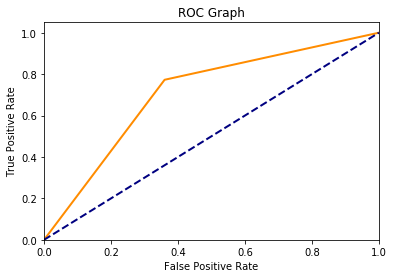

In [19]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

In [22]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1), max_df=1.0, min_df=1)
cv.fit(xTrain)

plot_coefficients(cls, cv.get_feature_names())

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [118]:
topFeatureList3 = np.append(topFeatureList2, getTopCoefficients(cls, cv.get_feature_names()))
print(len(topFeatureList3))

120


In [149]:
dfTemp = dfPublicHS.filter(items = topFeatureList, axis = 1)
dfTemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 2 columns):
lea_state_perpupil_num      470 non-null float64
lea_supplies_expense_pct    470 non-null float64
dtypes: float64(2)
memory usage: 7.4 KB


In [ ]:
# Source: https://stackoverflow.com/questions/34649969/how-to-find-the-features-names-of-the-coefficients-using-scikit-linear-regressio
coef_dict = {}
for coef, feat in zip(cls.coef_[0,:], X.columns):
    coef_dict[feat] = coef

for key, value in coef_dict.items():
    #print(key, value)

In [111]:
# Drop any columns that the value is the same for 90% of the records
#sel = VarianceThreshold(.90 * (1 - .90))
#sel.fit(dfPublicHS)
#keepCols = sel.get_support(indices=True)
#dfColIndex = np.arange(dfPublicHS.columns.size)
#dropCol = np.delete(dfColIndex, keepCols)
#dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)
#dfPublicHS.shape

In [9]:
# code to determine the number of highly correlated variables to drop for given r.
r = .95
while (r >= .80):
    to_drop = [column for column in upper.columns if any(upper[column] > r)]
    print('For r of ', r, 'drop # is:', len(to_drop) )
    r = r-.01
    r = round(r,2)
# print the list of columns to drop for the last iteration of the while loop.    
to_drop

## I can't get this to work!! Uncomment it to see the error##
#dfDropped = dfPublicHS.drop(to_drop, axis=1)

For r of  0.95 drop # is: 0
For r of  0.94 drop # is: 11
For r of  0.93 drop # is: 22
For r of  0.92 drop # is: 28
For r of  0.91 drop # is: 34
For r of  0.9 drop # is: 42
For r of  0.89 drop # is: 51
For r of  0.88 drop # is: 58
For r of  0.87 drop # is: 66
For r of  0.86 drop # is: 72
For r of  0.85 drop # is: 80
For r of  0.84 drop # is: 88
For r of  0.83 drop # is: 99
For r of  0.82 drop # is: 107
For r of  0.81 drop # is: 116
For r of  0.8 drop # is: 124


['lea_state_perpupil_num',
 '4-Year Cohort Graduation Rate Score',
 'ACTMath_ACTBenchmark_All',
 'ACTScience_ACTBenchmark_All',
 'ACTWorkKeys_SilverPlus_All',
 'ACTWriting_ACTBenchmark_All',
 'EOCSubjects_CACR_All',
 'ACTCompositeScore_UNCMin_Female',
 'ACTEnglish_ACTBenchmark_Female',
 'ACTMath_ACTBenchmark_Female',
 'ACTReading_ACTBenchmark_Female',
 'ACTScience_ACTBenchmark_Female',
 'ACTWorkKeys_SilverPlus_Female',
 'EOCBiology_CACR_Female',
 'EOCEnglish2_CACR_Female',
 'GraduationRate_5yr_Female',
 'ACTCompositeScore_UNCMin_Male',
 'ACTMath_ACTBenchmark_Male',
 'ACTScience_ACTBenchmark_Male',
 'ACTWorkKeys_SilverPlus_Male',
 'ACTWriting_ACTBenchmark_Male',
 'EOCBiology_CACR_Male',
 'EOCEnglish2_CACR_Male',
 'EOCMathI_CACR_Male',
 'ACTMath_ACTBenchmark_AmericanIndian',
 'ACTWorkKeys_SilverPlus_AmericanIndian',
 'ACTWriting_ACTBenchmark_AmericanIndian',
 'EOCBiology_CACR_AmericanIndian',
 'EOCEnglish2_CACR_AmericanIndian',
 'EOCMathI_CACR_AmericanIndian',
 'GraduationRate_4yr_Americ

In [ ]:
# Cool Plot
# http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py

## Model Advantages (10 points)
<span style="color: blue">Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</span>

## Interpret Feature Importance (30 points)

<span style="color: blue">Use the weights from logistic regression to interpret the importance of different features for the classification task. <b>Explain your interpretation in detail.</b>Why do you think some variables are more important?

## Interpret Support Vectors (10 points)
<span style="color:blue">Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.